# Setup

## Imports

In [87]:
# builtins
from __future__ import annotations
from collections import defaultdict, deque
from dataclasses import dataclass
from enum import Enum
from functools import cmp_to_key, reduce
from math import prod

# own stuff
from utils import Stopwatch, chunksof

# external stuff
import numpy as np
import matplotlib.pyplot as plt

## Timing

In [2]:
stopwatch = Stopwatch()
stopwatch.start()

# Day 1

## Process input

In [3]:
with open('inputs/01') as f:
    chunks = f.read().rstrip().split('\n\n')
cals = [sum(int(n) for n in c.splitlines()) for c in chunks]

## Part 1

In [4]:
print(max(cals))
stopwatch.add_split()

74394


## Part 2

In [5]:
print(sum(sorted(cals)[-3:]))
stopwatch.add_split()

212836


# Day 2

## Process input

In [6]:
mapping = {
    'A': 0, 'B': 1, 'C': 2,
    'X': 0, 'Y': 1, 'Z': 2,
}

with open('inputs/02') as f:
    rounds = [(mapping[a], mapping[b]) for a, b in (line.strip().split() for line in f)]

## Part 1

In [7]:
succ = lambda a: (a + 1) % 3
pred = lambda a: (a - 1) % 3
    
def score_round(a, b):
    if a == b:
        return b + 4
    elif b == succ(a):
        return b + 7
    else:
        return b + 1

print(sum(score_round(*x) for x in rounds))
stopwatch.add_split()

9241


## Part 2

In [8]:
def score_round(a, b):
    if b == 0:
        return pred(a) + 1
    elif b == 1:
        return a + 4
    else:
        return succ(a) + 7

print(sum(score_round(*x) for x in rounds))
stopwatch.add_split()

14610


# Day 3

## Process input

In [9]:
def to_sack(contents):
    n = len(contents)
    assert n % 2 == 0
    i = n//2
    return set(contents[:i]), set(contents[i:])

with open('inputs/03') as f:
    sacks = [to_sack(line.rstrip()) for line in f]

## Part 1

In [10]:
def priority(item):
    if 'a' <= item <= 'z':
        return ord(item) - ord('a') + 1
    else:
        return ord(item) - ord('A') + 27

print(sum(priority(*(a & b)) for a, b in sacks))
stopwatch.add_split()

7824


## Part 2

In [11]:
merged = (a | b for a, b in sacks)
groups = chunksof(3, merged)
badges = (a & b & c for a, b, c in groups)
print(sum(priority(*b) for b in badges))
stopwatch.add_split()

2798


# Day 4

## Process input

In [12]:
def parse_range(r):
    start, end = r.split('-')
    return int(start), int(end)

def parse_row(r):
    a, b = r.rstrip().split(',')
    return parse_range(a), parse_range(b)

with open('inputs/04') as f:
    pairs = [parse_row(r) for r in f]

## Part 1

In [13]:
def intersect(a, b):
    (x, y) = a
    (z, w) = b
    overlap = x <= w and y >= z
    if overlap:
        return (max(x, z), min(y, w))
    else:
        return None

def fully_contained(a, b):
    x = intersect(a, b)
    return a == x or b == x

print(sum(1 for a, b in pairs if fully_contained(a, b)))
stopwatch.add_split()

498


## Part 2

In [14]:
print(sum(1 for a, b in pairs if intersect(a, b) != None))
stopwatch.add_split()

859


# Day 5

## Process input

In [15]:
def parse_container_line(s):
    containers = []
    for i, j in enumerate(range(1, len(s), 4)):
        if s[j] == ' ':
            continue
        containers.append((i, s[j]))
    return containers

def parse_command_line(s):
    parts = s.split()
    return int(parts[1]), int(parts[3]) - 1, int(parts[5]) - 1

with open('inputs/05') as f:
    container_string, command_string = f.read().rstrip().split('\n\n')

container_lines = container_string.split('\n')
command_lines = command_string.split('\n')

num_stacks = len(container_lines[-1].strip().split())
stacks = [[] for _ in range(num_stacks)]
for line in reversed(container_lines[:-1]):
    for stack, container in parse_container_line(line):
        stacks[stack].append(container)

commands = [parse_command_line(l) for l in command_lines]

## Part 1

In [16]:
def apply(command, stacks):
    num, src, dst = command
    for _ in range(num):
        stacks[dst].append(stacks[src].pop())

stacks_copy = [s.copy() for s in stacks]
for c in commands:
    apply(c, stacks_copy)
    
print(''.join(s[-1] for s in stacks_copy))
stopwatch.add_split()

TPGVQPFDH


## Part 2

In [17]:
def apply(command, stacks):
    num, src, dst = command
    stacks[dst] += stacks[src][-num:]
    del stacks[src][-num:]

stacks_copy = [s.copy() for s in stacks]
for c in commands:
    apply(c, stacks_copy)
    
print(''.join(s[-1] for s in stacks_copy))
stopwatch.add_split()

DMRDFRHHH


# Day 6

## Process input

In [18]:
with open('inputs/06') as f:
    signal = f.read().rstrip()

## Part 1

In [19]:
def marker_index(num_chars, signal):
    for i in range(0, len(signal)-num_chars):
        j = i + num_chars
        if len(set(signal[i:j])) == num_chars:
            return j
        
    assert False, "A signal start was not found"

print(marker_index(4, signal))
stopwatch.add_split()

1794


## Part 2

In [20]:
print(marker_index(14, signal))
stopwatch.add_split()

2851


# Day 7

## Process input

In [21]:
@dataclass
class Directory:
    name: str
    contents: dict[str, Node]
    
    def __eq__(self, other):
        return self.name == other.name

@dataclass
class File:
    name: str
    size: int
    
    def __eq__(self, other):
        return self.name == other.name

Node = Directory | File

def parse_node(s):
    match s.split():
        case ["dir", name]:
            return Directory(name, {})
        case [size, name]:
            return File(name, int(size))

with open('inputs/07') as f:
    blocks = [b.strip().split('\n') for b in f.read().split('$')[1:]]

root = Directory('root', {})
current = root
history = []
for cmd, *output in blocks:
    match cmd.split():
        case ['cd', '/']:
            current = root
            history = []
        case ['cd', '..']:
            current = history.pop()
        case ['cd', dst]:
            history.append(current)
            current = current.contents[dst]
        case ['ls']:
            nodes = (parse_node(s) for s in output)
            current.contents = {n.name: n for n in nodes}

## Part 1

In [22]:
def dirsizes(directory):
    self_size = 0
    sizes = []
    for node in directory.contents.values():
        match node:
            case File(_, sz):
                self_size += sz
            case Directory(_, _):
                sizes += dirsizes(node)
                self_size += sizes[-1]
    sizes.append(self_size)
    return sizes

ds = dirsizes(root)
print(sum(sz for sz in ds if sz <= 100_000))
stopwatch.add_split()

1453349


## Part 2

In [23]:
min_del_size = 30_000_000 - (70_000_000 - ds[-1])

print(min(sz for sz in ds if sz >= min_del_size))
stopwatch.add_split()

2948823


# Day 8

## Process input

In [24]:
with open('inputs/08') as f:
    trees = np.array([[int(c) for c in row.rstrip()] for row in f], dtype=int)

## Part 1

In [25]:
def visible(trees):
    (m, n) = trees.shape
    vis = np.ones_like(trees, dtype=bool)
    rows = np.s_[1:m-1]
    cols = np.s_[1:n-1]
    vis[rows, cols] = False
    
    # horizontal
    for j in range(1, n-1):
        h = trees[rows, j]
        vis[rows, j] |= np.all(trees[rows,    :j].T < h, axis=0)
        vis[rows, j] |= np.all(trees[rows, j+1: ].T < h, axis=0)
    
    # vertical
    for i in range(1, m-1):
        h = trees[i, cols]
        vis[i, cols] |= np.all(trees[   :i, cols] < h, axis=0)
        vis[i, cols] |= np.all(trees[i+1: , cols] < h, axis=0)
    
    return vis
    

print(visible(trees).sum())
stopwatch.add_split()

1679


## Part 2

In [26]:
def num_vis(trees, h):
    vis = np.multiply.accumulate(trees < h, dtype=bool, axis=0)
    n = np.sum(vis, axis=0)
    n[np.logical_not(np.all(vis, axis=0))] += 1
    return n

def scenic_score(trees):
    (m, n) = trees.shape
    score = np.zeros_like(trees)
    rows = np.s_[1:m-1]
    cols = np.s_[1:n-1]
    score[rows, cols] = 1
    
    # horizontal
    for j in range(1, n-1):
        h = trees[rows, j]
        score[rows, j] *= num_vis(trees[rows, j-1::-1].T, h)
        score[rows, j] *= num_vis(trees[rows, j+1:   ].T, h)
    
    # vertical
    for i in range(1, m-1):
        h = trees[i, cols]
        score[i, cols] *= num_vis(trees[i-1::-1, cols], h)
        score[i, cols] *= num_vis(trees[i+1:   , cols], h)
    
    return score

print(np.amax(scenic_score(trees)))
stopwatch.add_split()

536625


# Day 9

## Process input

In [27]:
def parse_motions(f):
    for l in f:
        d, n = l.rstrip().split()
        if d == 'U':
            d = [0, 1]
        elif d == 'D':
            d = [0, -1]
        elif d == 'L':
            d = [-1, 0]
        else:
            d = [1, 0]
        
        for _ in range(int(n)):
            yield d
        

with open('inputs/09') as f:
    motions = np.array(list(parse_motions(f)), dtype=int)

## Part 1

In [28]:
def dt(h, t):
    distance = h - t
    dt = np.zeros(2, dtype=int)
    if np.amax(np.abs(distance)) <= 1:
        return dt
    else:
        return np.sign(distance)

def simulate(motions, num_knots):
    num_steps = len(motions) + 1
    knots = np.zeros((num_knots, num_steps, 2))
    knots[0] = np.add.accumulate(np.insert(motions, 0, 0, axis=0))
    
    for knot in range(1, num_knots):
        for step in range(1, num_steps):
            h = knots[knot-1, step  , :]
            t = knots[knot  , step-1, :]
            knots[knot, step, :] = t + dt(h, t)
    
    return knots

knots = simulate(motions, 2)
print(len({(x, y) for x, y in knots[1]}))
stopwatch.add_split()

6464


## Part 2

In [29]:
knots = simulate(motions, 10)
print(len({(x, y) for x, y in knots[-1]}))
stopwatch.add_split()

2604


# Day 10

## Process input

In [30]:
def run(instructions):
    x = 1
    for instruction in instructions:
        match instruction.split():
            case ['addx', num]:
                yield x
                yield x
                x += int(num)
            case ['noop']:
                yield x

with open('inputs/10') as f:
    x = np.fromiter(run(f.readlines()), dtype=int)

## Part 1

In [31]:
cycle = np.arange(1, len(x)+1)
idx = np.s_[19:221:40]
print(np.sum(x[idx]*cycle[idx]))
stopwatch.add_split()

16020


## Part 2

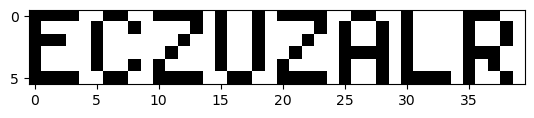

In [32]:
img = np.ones((6, 40))
for i in range(6):
    for j in range(40):
        spritepos = x[40*i + j]
        if spritepos - 1 <= j <= spritepos + 1:
            img[i, j] = 0

plt.imshow(img, cmap='gray')
plt.show()

stopwatch.add_split()

# Day 11

## Process input

In [33]:
class Monkey:
    def __init__(self, s):
        [idline, itemline, opline, testline, trueline, falseline] = [
            l.strip(' :') for l in s.splitlines()
        ]
        self.counter = 0
        
        match idline.split():
            case ['Monkey', num]:
                self.id = int(num)
            case _:
                raise ValueError(f'Failed to match {idline}')
                
        match itemline.split():
            case ['Starting', 'items:', *items]:
                self.initial_items = [int(it.rstrip(',')) for it in items]
                self.items = self.initial_items.copy()
            case _:
                raise ValueError(f'Failed to match {itemline}')
                
        match opline.split():
            case ['Operation:', 'new', '=', 'old', '+', 'old']:
                self.op = lambda x: x + x
            case ['Operation:', 'new', '=', 'old', '*', 'old']:
                self.op = lambda x: x * x
            case ['Operation:', 'new', '=', 'old', '+', y]:
                operand = int(y)
                self.op = lambda x: x + operand
            case ['Operation:', 'new', '=', 'old', '*', y]:
                operand = int(y)
                self.op = lambda x: x * operand
            case _:
                raise ValueError(f'Failed to match {opline}')
                
        match testline.split():
            case ['Test:', 'divisible', 'by', y]:
                divisor = int(y)
                self.div = divisor
                self.test = lambda x: x % divisor == 0
            case _:
                raise ValueError(f'Failed to match {testline}')
                
        match trueline.split():
            case ['If', 'true:', 'throw', 'to', 'monkey', y]:
                recipient_t = int(y)
                self.true = recipient_t
            case _:
                raise ValueError(f'Failed to match {trueline}')
                
        match falseline.split():
            case ['If', 'false:', 'throw', 'to', 'monkey', y]:
                recipient_f = int(y)
                self.false = recipient_f
            case _:
                raise ValueError(f'Failed to match {falseline}')
        
    def do_turn(self, monkies):
        for item in self.items:
            self.counter += 1
            item = self.op(item) // 3
            if self.test(item):
                monkies[self.true].items.append(item)
            else:
                monkies[self.false].items.append(item)
        self.items = []
    
    def do_turn_2(self, monkies, lcm):
        for item in self.items:
            self.counter += 1
            item = self.op(item) % lcm
            if self.test(item):
                monkies[self.true].items.append(item)
            else:
                monkies[self.false].items.append(item)
        self.items = []
    
    def reset(self):
        self.counter = 0
        self.items = self.initial_items.copy()

with open('inputs/11') as f:
    monkies = [Monkey(s) for s in f.read().rstrip().split('\n\n')]

## Part 1

In [34]:
for _ in range(20):
    for monkey in monkies:
        monkey.do_turn(monkies)

print(np.prod(np.sort([monkey.counter for monkey in monkies])[-2:]))

stopwatch.add_split()

54054


## Part 2

In [35]:
for m in monkies:
    m.reset()

lcm = np.lcm.reduce([m.div for m in monkies])

for _ in range(10000):
    for monkey in monkies:
        monkey.do_turn_2(monkies, lcm)

print(np.prod(np.sort([monkey.counter for monkey in monkies])[-2:]))

stopwatch.add_split()

14314925001


# Day 12

## Process input

In [36]:
elevations = []

with open('inputs/12') as f:
    for i, line in enumerate(f):
        el = []
        for j, c in enumerate(line.rstrip()):
            match c:
                case 'S':
                    el.append(0)
                    start = (i, j)
                case 'E':
                    el.append(ord('z') - ord('a'))
                    end = (i, j)
                case _:
                    el.append(ord(c) - ord('a'))
        elevations.append(el)

elevations = np.array(elevations)

## Part 1

In [37]:
def distances(elevations, start):
    (M, N) = elevations.shape
    def neighbors(i, j):
        return (
            (k, l)
            for k, l in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
            if k in range(M) and l in range(N)
            and elevations[i, j] + 1 >= elevations[k, l]
        )
    
    visit = deque([(start, 0)])
    visited = np.zeros_like(elevations, dtype=bool)
    steps = np.full(elevations.shape, np.iinfo(int).max)
    while len(visit) > 0:
        idx, counter = visit.popleft()
        if visited[idx]:
            continue
        steps[idx] = counter
        visited[idx] = True
        visit.extend(((nb, counter+1) for nb in neighbors(*idx) if not visited[nb]))

    return steps

print(distances(elevations, start)[end])
stopwatch.add_split()

330


## Part 2

In [38]:
print(distances(-elevations, end)[elevations == 0].min())
stopwatch.add_split()

321


# Day 13

## Process input

In [39]:
with open('inputs/13') as f:
    packets = [eval(p) for p in f.read().split()]

## Part 1

In [40]:
def compare(a, b):
    match (a, b):
        case (int(x), int(y)):
            return x - y
        case (int(x), list(ys)):
            return compare([x], ys)
        case (list(xs), int(y)):
            return compare(xs, [y])
        case ([], []):
            return 0
        case ([], [y, *ys]):
            return -1
        case ([x, *xs], []):
            return 1
        case ([x, *xs], [y, *ys]):
            return cmp if (cmp := compare(x, y)) != 0 else compare(xs, ys)
        case _:
            raise ValueError("No match")

pairs = zip(packets[0::2], packets[1::2])
print(sum(i+1 for i, p in enumerate(pairs) if compare(*p) < 0))

stopwatch.add_split()

5682


## Part 2

In [41]:
dividers = [ [[2]], [[6]] ]
sorted_packets = sorted(packets + dividers, key=cmp_to_key(compare))
print(prod(sorted_packets.index(d) + 1 for d in dividers))

stopwatch.add_split()

20304


# Day 14

## Process input

In [42]:
Tile = Enum('Tile', ['ROCK', 'SAND'])
initial_cave = {}

def connect(points):
    for a, b in zip(points[:-1], points[1:]):
        d = np.sign(b - a)
        k = 0
        while not np.all((p := a + k*d) == b):
            yield p[0], p[1]
            k += 1
    yield b[0], b[1]
            
with open('inputs/14') as f:
    for line in f:
        points = np.array([eval(p) for p in line.rstrip().split(' -> ')])
        initial_cave |= {p: Tile.ROCK for p in connect(points)}

## Part 1

In [43]:
cave = initial_cave.copy()
lowest_rock = max(y for _, y in cave)

visit = [(500, 0)]
count = 0
while True:
    x, y = visit[-1]
    if y == lowest_rock:
        break
        
    neighbors = tuple(p for p in ((x+1, y+1), (x-1, y+1), (x, y+1)) if p not in cave)
    if not neighbors:
        cave[visit.pop()] = Tile.SAND
        count += 1
    else:
        visit.extend(neighbors)

print(count)
stopwatch.add_split()

638


## Part 2

In [44]:
cave = initial_cave.copy()
floor_level = max(y for _, y in cave) + 2

visit = [(500, 0)]
count = 0
while visit:
    x, y = visit.pop()
    cave[x, y] = Tile.SAND
    count += 1
    if y < floor_level - 1:
        visit.extend(p for p in ((x+1, y+1), (x-1, y+1), (x, y+1)) if p not in cave)

print(count)
stopwatch.add_split()

31722


# Day 15

## Process input

In [45]:
def parse(line):
    parts = [p.strip('xy=:,') for p in line.split()]
    return (int(parts[2]), int(parts[3])), (int(parts[8]), int(parts[9]))

with open('inputs/15') as f:
    sensors, beacons = (list(x) for x in zip(*(parse(l) for l in f)))

## Part 1

In [46]:
def dist(p, q):
    match p, q:
        case (x, y), (z, w):
            return abs(x - z) + abs(y - w)
        case _:
            raise ValueError(f'Invalid points {p}, {q}')

def merge(unmerged):
    if not unmerged:
        return []
    
    merged = [unmerged[0]]
    i = 0
    j = 1
    while j < len(unmerged):
        a, b = merged[i]
        c, d = unmerged[j]
        if c <= b:
            merged[i] = (a, max(b, d))
        else:
            merged.append((c, d))
            i += 1
        j += 1
    return merged
            
ranges = [dist(s, b) for s, b in zip(sensors, beacons)]
y = 2_000_000
no_beacons = merge(sorted(
    (sx - dx, sx + dx + 1)
    for (sx, sy), r in zip(sensors, ranges)
    if (dx := r - abs(sy - y)) >= 0
))

num_beacons = sum(1 for _, by in set(beacons) if by == y)
print(sum(b - a for a, b in no_beacons) - num_beacons)

stopwatch.add_split()

4907780


## Part 2

In [47]:
N = 4_000_000
found = False
for y in range(N+1):
    no_beacons = merge(sorted(
        (max(0, a), min(N+1, b))
        for (sx, sy), r in zip(sensors, ranges)
        if (dx := r - abs(sy - y)) >= 0
        if (a := sx - dx) <= N
        if (b := sx + dx + 1) > 0
    ))
    a, b = no_beacons[0]
    if (a, b) == (0, N+1):
        continue
    
    x = b if a == 0 else a-1
    break
    
else:
    raise RuntimeError('Beacon not found :(')

print(4_000_000 * x + y)

stopwatch.add_split()

13639962836448


# Day 16

## Process input

In [112]:
def parse(row):
    parts = row.split()
    valve = parts[1]
    flow_rate = int(parts[4].strip('rate=;'))
    neighbors = [p.rstrip(',') for p in parts[9:]]
    return valve, (flow_rate, neighbors)

with open('inputs/16') as f:
    rows = [parse(row) for row in f]
    
graph = {v: vs for v, (_, vs) in rows}
flow_rate = {v: f for v, (f, _) in rows}

## Part 1

In [113]:
def max_release(graph, flow_rate):
    history = set()
    visit = [('AA', frozenset(), 0)]
    for t in range(30, 0, -1):
        states = defaultdict(lambda: 0)
        for u, opened, value in visit:
            if states[u, opened] < value:
                history.add((u, opened, value))
                states[(u, opened)] = value
        
        visit = []
        for (u, opened), value in states.items():
            if u not in opened and flow_rate[u] > 0:
                u_open = opened | {u}
                u_value = value + (t-1)*flow_rate[u]
                if (u, u_open, u_value) not in history:
                    visit.append((u, u_open, u_value))
            visit.extend((v, opened, value) for v in graph[u] if (v, opened, value) not in history)
                
            
    return max(states.values())

print(max_release(graph, flow_rate))

2119


## Part 2

# Day X

## Process input

## Part 1

## Part 2

# Performance analysis

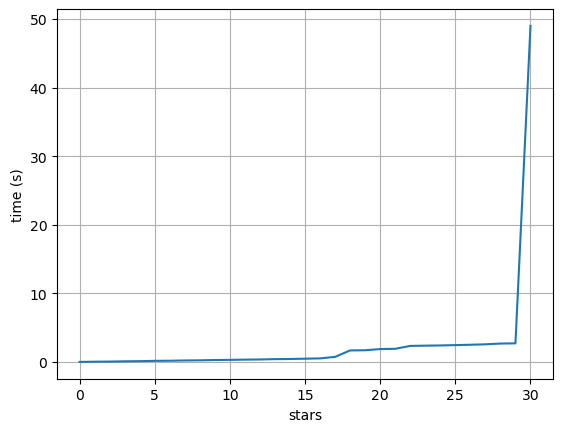

In [48]:
t = np.array(stopwatch.stop(add_split=False), dtype=int)
plt.plot(np.arange(len(t)), t / 1e9)
plt.xlabel('stars')
plt.ylabel('time (s)')
plt.grid('on')
plt.show()